## Work
1. 請嘗試將 preproc_x 替換成以每筆資料的 min/max 進行標準化至 -1 ~ 1 間，再進行訓練
2. 請嘗試將 mlp 疊更深 (e.g 5~10 層)，進行訓練後觀察 learning curve 的走勢
3. (optional) 請改用 GPU 進行訓練 (如果你有 GPU 的話)，比較使用 CPU 與 GPU 的訓練速度

In [1]:
## 確認硬體資源 (如果你是在 Linux, 若是在 Windows, 請參考 https://blog.csdn.net/idwtwt/article/details/78017565)
#!nvidia-smi

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


['/job:localhost/replica:0/task:0/device:GPU:0']


In [2]:
import os
import keras

# 請嘗試設定 GPU：os.environ
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [3]:
# 如果使用 GPU時，顯示卡分配記憶體空間遇到 Blas GEMM launch failed 錯誤
# 比較保險是在模型訓練之前先分配好空間
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [4]:
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
"""
Your code here
"""
import numpy as np
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_x_MM(x, flatten=True):
    maxvals = np.max(x, axis = (1, 2, 3))
    maxvals = np.repeat(maxvals, np.prod(x.shape[1:])).reshape(x.shape)
    minvals = np.min(x, axis = (1, 2, 3))
    minvals = np.repeat(minvals, np.prod(x.shape[1:])).reshape(x.shape)
    x = 2 * ((x-minvals)/(maxvals-minvals)-0.5)
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y  

# 1. 將 preproc_x 替換成以每筆資料的 min/max 進行標準化至 -1 ~ 1 間 (GPU)

In [6]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x_MM(x_train)
x_test = preproc_x_MM(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
"""Code Here
建立你的神經網路
"""
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


In [8]:
## 超參數設定
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 256

In [9]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [10]:
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 6s 117us/step - loss: 1.6467 - acc: 0.4186 - val_loss: 1.5106 - val_acc: 0.4604
Epoch 2/100
50000/50000 [==============================] - 5s 104us/step - loss: 1.4195 - acc: 0.4967 - val_loss: 1.4222 - val_acc: 0.4926
Epoch 3/100
50000/50000 [==============================] - 5s 104us/step - loss: 1.2941 - acc: 0.5420 - val_loss: 1.3946 - val_acc: 0.5107
Epoch 4/100
50000/50000 [==============================] - 5s 103us/step - loss: 1.1993 - acc: 0.5764 - val_loss: 1.3757 - val_acc: 0.5231
Epoch 5/100
50000/50000 [==============================] - 5s 104us/step - loss: 1.1095 - acc: 0.6103 - val_loss: 1.3850 - val_acc: 0.5204
Epoch 6/100
50000/50000 [==============================] - 5s 103us/step - loss: 1.0223 - acc: 0.6402 - val_loss: 1.3876 - val_acc: 0.5317
Epoch 7/100
50000/50000 [==============================] - 5s 103us/step - loss: 0.9388 - acc: 0.6699 - val_loss: 1.

50000/50000 [==============================] - 5s 103us/step - loss: 0.0946 - acc: 0.9688 - val_loss: 4.0439 - val_acc: 0.5289
Epoch 60/100
50000/50000 [==============================] - 5s 103us/step - loss: 0.0878 - acc: 0.9715 - val_loss: 4.0375 - val_acc: 0.5249
Epoch 61/100
50000/50000 [==============================] - 5s 103us/step - loss: 0.0747 - acc: 0.9756 - val_loss: 4.0020 - val_acc: 0.5283
Epoch 62/100
50000/50000 [==============================] - 5s 104us/step - loss: 0.0651 - acc: 0.9778 - val_loss: 4.1402 - val_acc: 0.5243
Epoch 63/100
50000/50000 [==============================] - 5s 103us/step - loss: 0.0964 - acc: 0.9694 - val_loss: 4.1458 - val_acc: 0.5202
Epoch 64/100
50000/50000 [==============================] - 5s 104us/step - loss: 0.0980 - acc: 0.9686 - val_loss: 4.0667 - val_acc: 0.5160
Epoch 65/100
50000/50000 [==============================] - 5s 105us/step - loss: 0.0951 - acc: 0.9683 - val_loss: 4.0931 - val_acc: 0.5220
Epoch 66/100
50000/50000 [=======

In [11]:
import matplotlib.pyplot as plt
%matplotlib inline

def plot_train_history(model):
    train_loss = model.history.history["loss"]
    valid_loss = model.history.history["val_loss"]

    train_acc = model.history.history["acc"]
    valid_acc = model.history.history["val_acc"]

    plt.plot(range(len(train_loss)), train_loss, label="train loss")
    plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
    plt.legend()
    plt.title("Loss")
    plt.show()

    plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
    plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
    plt.legend()
    plt.title("Accuracy")
    plt.show()

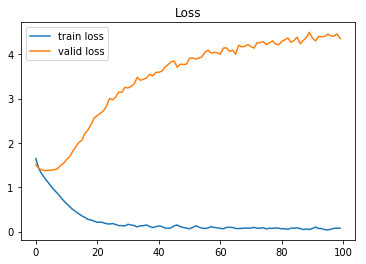

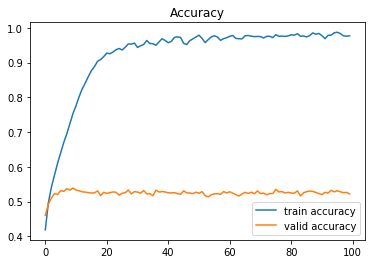

In [12]:
plot_train_history(model)

# 2. 將 mlp 疊更深 (e.g 5~10 層)，進行訓練後觀察 learning curve 的走勢 (GPU)

In [13]:
x_train, y_train = train
x_test, y_test = test

# Preproc the inputs
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# Preprc the outputs
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [14]:
"""Code Here
建立你的神經網路
"""
def build_mlp2(input_shape, output_units=10, num_neurons=[512, 256, 128, 64, 32]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

model2 = build_mlp2(input_shape=x_train.shape[1:])
model2.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_2 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
hidden_layer4 (Dense)        (None, 64)                8256      
_________________________________________________________________
hidden_layer5 (Dense)        (None, 32)                2080      
_________________________________________________________________
output (Dense)               (None, 10)                330       
Total para

In [15]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model2.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [16]:
model2.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 6s 128us/step - loss: 1.9843 - acc: 0.2689 - val_loss: 1.8456 - val_acc: 0.3297
Epoch 2/100
50000/50000 [==============================] - 5s 105us/step - loss: 1.7576 - acc: 0.3659 - val_loss: 1.7658 - val_acc: 0.3669
Epoch 3/100
50000/50000 [==============================] - 5s 104us/step - loss: 1.6556 - acc: 0.4072 - val_loss: 1.5912 - val_acc: 0.4325
Epoch 4/100
50000/50000 [==============================] - 5s 105us/step - loss: 1.5866 - acc: 0.4310 - val_loss: 1.5741 - val_acc: 0.4391
Epoch 5/100
50000/50000 [==============================] - 5s 104us/step - loss: 1.5374 - acc: 0.4491 - val_loss: 1.5634 - val_acc: 0.4410
Epoch 6/100
50000/50000 [==============================] - 5s 106us/step - loss: 1.4831 - acc: 0.4682 - val_loss: 1.4670 - val_acc: 0.4762
Epoch 7/100
50000/50000 [==============================] - 5s 107us/step - loss: 1.4592 - acc: 0.4791 - val_loss: 1.

50000/50000 [==============================] - 5s 106us/step - loss: 0.5799 - acc: 0.7915 - val_loss: 2.0320 - val_acc: 0.5172
Epoch 60/100
50000/50000 [==============================] - 5s 107us/step - loss: 0.5975 - acc: 0.7844 - val_loss: 2.0033 - val_acc: 0.5226
Epoch 61/100
50000/50000 [==============================] - 5s 106us/step - loss: 0.5699 - acc: 0.7929 - val_loss: 1.9759 - val_acc: 0.5104
Epoch 62/100
50000/50000 [==============================] - 5s 106us/step - loss: 0.5647 - acc: 0.7969 - val_loss: 2.0278 - val_acc: 0.5079
Epoch 63/100
50000/50000 [==============================] - 5s 106us/step - loss: 0.5410 - acc: 0.8042 - val_loss: 2.0594 - val_acc: 0.5153
Epoch 64/100
50000/50000 [==============================] - 5s 106us/step - loss: 0.5331 - acc: 0.8084 - val_loss: 2.0826 - val_acc: 0.5073
Epoch 65/100
50000/50000 [==============================] - 5s 106us/step - loss: 0.5237 - acc: 0.8120 - val_loss: 2.1026 - val_acc: 0.5136
Epoch 66/100
50000/50000 [=======

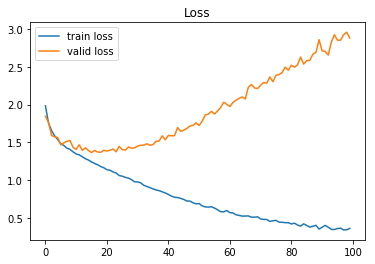

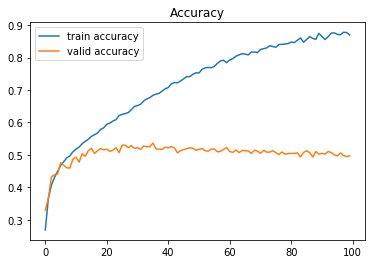

In [17]:
plot_train_history(model2)

# 範例檔結果 (CPU)

## 範例重點
### 學習在模型開始前檢查各個環節
1. 是否有 GPU 資源
2. 將前處理轉為函式，統一處理訓練、驗證與測試集
3. 將超參數變數化，易於重複使用函式、模型等

In [1]:
## 確認硬體資源 (如果你是在 Linux, 若是在 Windows, 請參考 https://blog.csdn.net/idwtwt/article/details/78017565)
#!nvidia-smi

from keras import backend as K
print(K.tensorflow_backend._get_available_gpus())

Using TensorFlow backend.


[]


In [2]:
# 如果使用 GPU時，顯示卡分配記憶體空間遇到 Blas GEMM launch failed 錯誤
# 比較保險是在模型訓練之前先分配好空間
import tensorflow as tf
from keras.backend.tensorflow_backend import set_session
config = tf.ConfigProto()
config.gpu_options.allocator_type = 'BFC' #A "Best-fit with coalescing" algorithm, simplified from a version of dlmalloc.
config.gpu_options.per_process_gpu_memory_fraction = 0.3
config.gpu_options.allow_growth = True
set_session(tf.Session(config=config))

In [3]:
import os
import keras

# 本範例不需使用 GPU, 將 GPU 設定為 "無"
os.environ["CUDA_VISIBLE_DEVICES"] = ""

In [4]:
# 從 Keras 的內建功能中，取得 train 與 test 資料集
train, test = keras.datasets.cifar10.load_data()

In [5]:
## 資料前處理
def preproc_x(x, flatten=True):
    x = x / 255.
    if flatten:
        x = x.reshape((len(x), -1))
    return x

def preproc_y(y, num_classes=10):
    if y.shape[-1] == 1:
        y = keras.utils.to_categorical(y, num_classes)
    return y    

In [6]:
x_train, y_train = train
x_test, y_test = test

# 資料前處理 - X 標準化
x_train = preproc_x(x_train)
x_test = preproc_x(x_test)

# 資料前處理 -Y 轉成 onehot
y_train = preproc_y(y_train)
y_test = preproc_y(y_test)

In [7]:
def build_mlp(input_shape, output_units=10, num_neurons=[512, 256, 128]):
    input_layer = keras.layers.Input(input_shape)
    
    for i, n_units in enumerate(num_neurons):
        if i == 0:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(input_layer)
        else:
            x = keras.layers.Dense(units=n_units, activation="relu", name="hidden_layer"+str(i+1))(x)
    
    out = keras.layers.Dense(units=output_units, activation="softmax", name="output")(x)
    
    model = keras.models.Model(inputs=[input_layer], outputs=[out])
    return model

In [8]:
model = build_mlp(input_shape=x_train.shape[1:])
model.summary()

Instructions for updating:
Colocations handled automatically by placer.
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 3072)              0         
_________________________________________________________________
hidden_layer1 (Dense)        (None, 512)               1573376   
_________________________________________________________________
hidden_layer2 (Dense)        (None, 256)               131328    
_________________________________________________________________
hidden_layer3 (Dense)        (None, 128)               32896     
_________________________________________________________________
output (Dense)               (None, 10)                1290      
Total params: 1,738,890
Trainable params: 1,738,890
Non-trainable params: 0
_________________________________________________________________


In [9]:
## 超參數設定
LEARNING_RATE = 0.001
EPOCHS = 100
BATCH_SIZE = 256

In [10]:
optimizer = keras.optimizers.Adam(lr=LEARNING_RATE)
model.compile(loss="categorical_crossentropy", metrics=["accuracy"], optimizer=optimizer)

In [11]:
model.fit(x_train, y_train, 
          epochs=EPOCHS, 
          batch_size=BATCH_SIZE, 
          validation_data=(x_test, y_test), 
          shuffle=True)

Instructions for updating:
Use tf.cast instead.
Train on 50000 samples, validate on 10000 samples
Epoch 1/100
50000/50000 [==============================] - 9s 188us/step - loss: 1.9450 - acc: 0.2978 - val_loss: 1.8009 - val_acc: 0.3442
Epoch 2/100
50000/50000 [==============================] - 10s 192us/step - loss: 1.7128 - acc: 0.3846 - val_loss: 1.6553 - val_acc: 0.4100
Epoch 3/100
50000/50000 [==============================] - 9s 185us/step - loss: 1.6075 - acc: 0.4246 - val_loss: 1.5585 - val_acc: 0.4459
Epoch 4/100
50000/50000 [==============================] - 9s 177us/step - loss: 1.5502 - acc: 0.4456 - val_loss: 1.5284 - val_acc: 0.4551
Epoch 5/100
50000/50000 [==============================] - 9s 177us/step - loss: 1.5008 - acc: 0.4633 - val_loss: 1.5364 - val_acc: 0.4562
Epoch 6/100
50000/50000 [==============================] - 9s 177us/step - loss: 1.4618 - acc: 0.4788 - val_loss: 1.5245 - val_acc: 0.4562
Epoch 7/100
50000/50000 [==============================] - 9s 178us

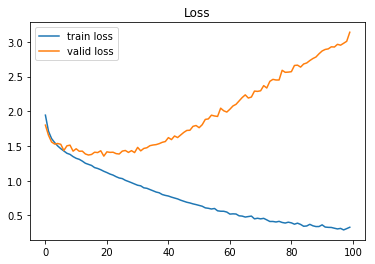

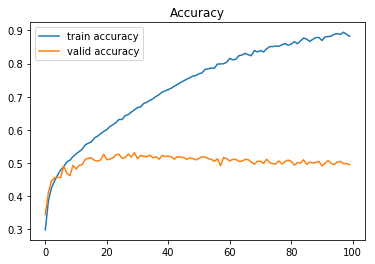

In [12]:
# 訓練模型並檢視驗證集的結果
import matplotlib.pyplot as plt
%matplotlib inline

train_loss = model.history.history["loss"]
valid_loss = model.history.history["val_loss"]

train_acc = model.history.history["acc"]
valid_acc = model.history.history["val_acc"]

plt.plot(range(len(train_loss)), train_loss, label="train loss")
plt.plot(range(len(valid_loss)), valid_loss, label="valid loss")
plt.legend()
plt.title("Loss")
plt.show()

plt.plot(range(len(train_acc)), train_acc, label="train accuracy")
plt.plot(range(len(valid_acc)), valid_acc, label="valid accuracy")
plt.legend()
plt.title("Accuracy")
plt.show()